In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Since the number of image file is large and it needs a very long time to upload them in google drive, we have to load and processed them in the local and compressed them into NPZ file. This part begin from the load NPZ file part.

## Import needed packages

In [0]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 1.2MB/s 


In [0]:
import pydicom
import glob, pylab
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
import numpy as np

import pydicom as dicom
import os
import cv2
import random

from numpy import savez_compressed
from keras.preprocessing import image
from numpy import load

from keras.preprocessing import image
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from numpy import savez_compressed
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Load CSV file (This part is in the first ipynb file)


In [0]:
Dir ='/content/drive/My Drive/Deep learning project/'
df = pd.read_csv(Dir+'data_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Exploratory Data Analysis

In [0]:
df = df.drop_duplicates('patientId')

In [0]:
df.Target.value_counts()

0    20672
1     6012
Name: Target, dtype: int64

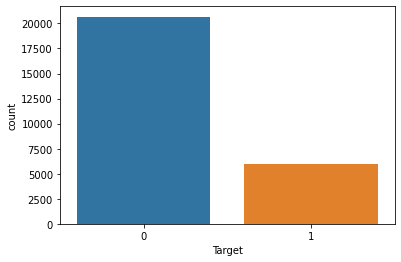

In [0]:
sns.countplot(x='Target', data = df)

In [0]:
df_heat = df.dropna()[['x', 'y', 'width', 'height']].copy()
df_heat['x_2'] = df_heat['x'] + df_heat['width']
df_heat['y_2'] = df_heat['y'] + df_heat['height']
df_heat['x_center'] = df_heat['x'] + df_heat['width'] / 2
df_heat['y_center'] = df_heat['y'] + df_heat['height'] / 2
df_heat['area'] = df_heat['width'] * df_heat['height']

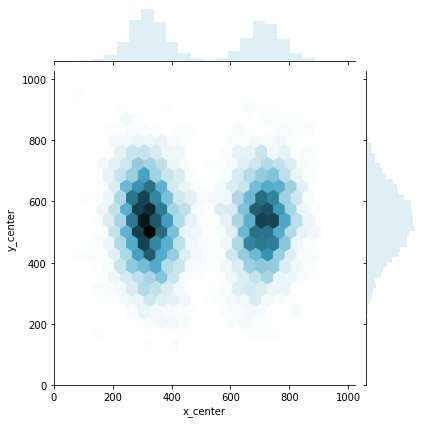

In [0]:
sns.jointplot(x = 'x_center', y = 'y_center', data = df_heat, kind = 'hex', gridsize = 20,ylim = (0,1024),xlim=(0, 1024), color = 'lightblue')

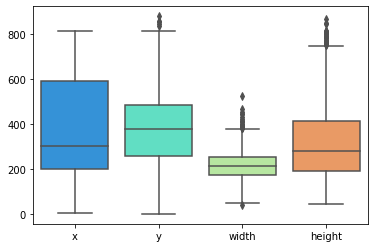

In [0]:
sns.boxplot(data=df_heat[['x','y','width','height']],palette='rainbow')

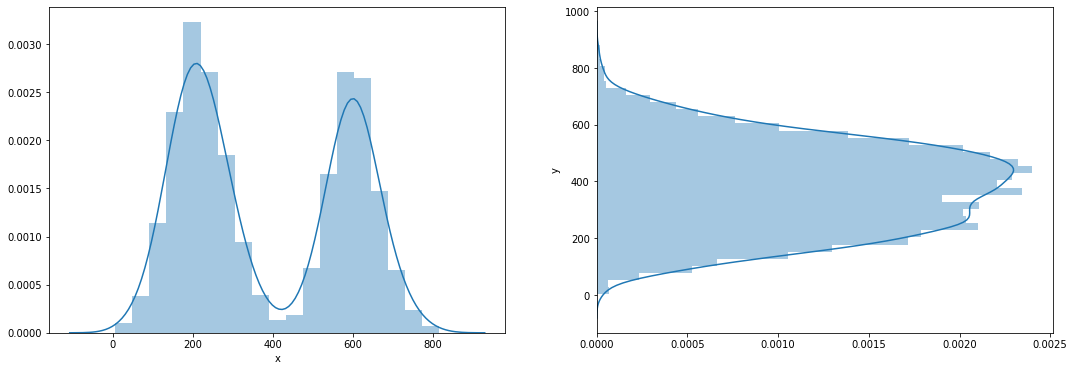

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df_heat['x'], ax =ax[0])
sns.distplot(df_heat['y'], ax= ax[1], vertical = True)

In [0]:
# load and shuffle images
image_names = os.listdir(Dir + 'stage_2_train_images')
random.seed(234)
random.shuffle(image_names)
image_names[0:10]

In [0]:
# load and shuffle images
image_names = os.listdir(Dir + 'stage_2_train_images')
random.seed(234)
random.shuffle(image_names)
image_names[0:10]

In [0]:
# split into train, validation, test filenames
number_train_samples = round(num_of_images * 0.7)
number_valid_samples = round(num_of_images * 0.2)
number_test_samples = num_of_images - number_train_samples - number_valid_samples

train_image = image_names[:number_train_samples]
valid_image = image_names[number_train_samples:number_train_samples+ number_valid_samples]
test_image = image_names[number_train_samples+ number_valid_samples:]

print('number of train samples', len(train_image))
print('number of valid samples', len(valid_image))
print('number of test samples', len(test_image))

In [0]:
# split csv file
train_name = [i.split('.')[0] for i in train_image]
valid_name = [i.split('.')[0] for i in valid_image]
test_name = [i.split('.')[0] for i in test_image]

print(train_name[0:1])
print(valid_name[0:1])
print(test_name[0:1])

In [0]:
train_data = df.loc[df.patientId.isin(train_name)]
valid_data = df.loc[df.patientId.isin(valid_name)]
test_data = df.loc[df.patientId.isin(test_name)]

print('number of train samples', train_data.shape)
print('number of valid samples', valid_data.shape)
print('number of test samples', test_data.shape)

In [0]:
print(train_data.Target.value_counts()[0]/train_data.Target.value_counts()[1])
print(valid_data.Target.value_counts()[0]/valid_data.Target.value_counts()[1])
print(test_data.Target.value_counts()[0]/test_data.Target.value_counts()[1])

## Load Image Data(This part is in the first ipynb file)

In [0]:
patientId = df['patientId'][0]
dcm_file = Dir+'stage_2_train_images/'+'%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

In [0]:
im = dcm_data.pixel_array
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [0]:
#Find the attribute of DCM_file
patientId = data['patientId'][0]
dcm_file = 'E:/Dataset/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

In [0]:
# show the image hidden in the dcm file
image = dcm_data.pixel_array
pylab.imshow(image, cmap=pylab.cm.gist_gray)
pylab.axis('off')

#### Create bounding box

In [0]:
# Create Bounding box for images
row = df.loc[df['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']
unhealth_person_patientId ='00436515-870c-4b36-a041-de91049b9ab4'
dcm_file_1 = Dir+'stage_2_train_images/'+'%s.dcm' % unhealth_person_patientId
dcm_data_1 = pydicom.read_file(dcm_file_1)
im_1 = dcm_data_1.pixel_array
fig,ax = plt.subplots(1)
pylab.imshow(im_1, cmap=pylab.cm.gist_gray)
pylab.axis('on')
pylab.plot(row['x'], row['y'], 's')
rect = patches.Rectangle(xy=(row.loc[4,'x'], row.loc[4,'y']),width=row.loc[4,'width'],
                         height=row.loc[4,'height'],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [0]:
unhealthy = df.loc[df.Target==1]
unhealthy.reset_index(inplace = True, drop =True)
unhealthy_example = unhealthy[0:10]
unhealthy_example

In [0]:
for patient in unhealthy_example['patientId']:
    i = 0
    row = unhealthy_example.loc[unhealthy_example['patientId'] == patient]
    dcm_file = Dir+'stage_2_train_images/'+'%s.dcm' % patient
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')
    fig,ax = plt.subplots(1)
    pylab.plot(row['x'], row['y'], 's')
    rect = patches.Rectangle(xy=(unhealthy_example.loc[i,'x'],
                                 unhealthy_example.loc[i,'y']),
                             width=unhealthy_example.loc[i,'width'],
                             height=unhealthy_example.loc[i, 'height'],
                             linewidth=1,edgecolor='r',facecolor='none')
    i = i+1
    ax.add_patch(rect)

#### Convert to jpg format

In [0]:
# Convert DCM file to JPG file
# Specify the .dcm folder path
folder_path = "E:\Dataset\stage_2_train_images"
# Specify the output jpg folder path
jpg_folder_path = "E:\Dataset\JPG_train"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array

    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 1000 == 0:
        print('{} image converted'.format(n))

#### Split images into training, validation, and testing datasets

In [0]:
# Create folders for train, validation and test
import shutil
jpg_path = 'E:/Dataset/JPG_train/'
for f in train_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/train')

for f in valid_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/validation')
    
for f in test_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/test')

In [0]:
#Sort valure in order to match the paitient and csv file
train_data.sort_values('patientId',inplace = True)
train_data.reset_index(inplace = True,drop = True)
train_image.sort()
train_data[0:5]

In [0]:
train_name.sort()
train_name[0:5]

In [0]:
# Validation
valid_data.sort_values('patientId',inplace = True)
valid_data.reset_index(inplace = True,drop = True)
valid_name.sort()
valid_data[0:5]

In [0]:
valid_name[0:5]

In [0]:
# test 
test_data.sort_values('patientId',inplace = True)
test_data.reset_index(inplace = True,drop = True)
test_name.sort()
test_data[0:5]

In [0]:
test_name[0:5]

In [0]:
# load train image data
train_images = []
train_path = 'E:/Dataset/train/'
for n, file in enumerate(train_name):
    
    img_path = train_path + file+'.jpg'
    img = cv2.imread(img_path)
    resize_image =  cv2.resize(img, (340,340), interpolation = cv2.INTER_AREA)
    train_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
x_train = np.array(train_images)

In [0]:
# load validation image data
valid_images = []
valid_path = 'E:/Dataset/validation/'
for n, file in enumerate(valid_name):
    
    img_path = valid_path + file+'.jpg'
    img = cv2.imread(img_path)
    resize_image =  cv2.resize(img, (340,340), interpolation = cv2.INTER_AREA)
    valid_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
x_valid = np.array(valid_images)

In [0]:
# load test image data
test_images = []
test_path = 'E:/Dataset/test/'
for n, file in enumerate(test_name):
    
    img_path = test_path + file+'.jpg'
    img = cv2.imread(img_path)
    resize_image =  cv2.resize(img, (340,340), interpolation = cv2.INTER_AREA)
    test_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
x_test = np.array(test_images)

In [0]:
print('the shape of training:',x_train.shape )
print('the shape of validation:',x_valid.shape )
print('the shape of test:', x_test.shape )

In [0]:
savez_compressed('val_data_1.npz', x_valid)
savez_compressed('test_data_1.npz', x_test)

In [0]:
savez_compressed('train_data_1.npz', x_train)

In [0]:
train_data.to_csv('train_data_1.csv',index = False)
valid_data.to_csv('valid_data_1.csv', index= False)
test_data.to_csv('test_data_1.csv',index = False)

## Load Preprocessed CSV and NPZ files (Load this file from here)

* Since the image size is too large to be uploaded in the google drive file, we did a more comprehensive EDA in local computer, which is saved in another python file, along with this one.

In [0]:
path = '/content/drive/My Drive/Deep learning project/'
train_data = load(path+'train_data_1.npz')
x_train = train_data['arr_0']
val_data = load(path+'val_data_1.npz')
x_val = val_data['arr_0']
test_data = load(path + 'test_data_1.npz')
x_test = test_data['arr_0']

In [0]:
train = pd.read_csv(path + "train_data.csv")
valid = pd.read_csv(path + "valid_data.csv")
test = pd.read_csv(path + "test_data.csv")

In [0]:
# make sure the shape is match
print("Image train dataset shape: ", x_train.shape, " train dataset shape: ", train.shape)
print("Image validation dataset shape: ", x_val.shape, "validation dataset shape: ", valid.shape)
print("Image test dataset shape: ", x_test.shape, "test dataset shape: ", test.shape)

Image train dataset shape:  (18679, 340, 340, 1)  train dataset shape:  (18679, 6)
Image validation dataset shape:  (5337, 340, 340, 1) validation dataset shape:  (5337, 6)
Image test dataset shape:  (2668, 340, 340, 1) test dataset shape:  (2668, 6)


In [0]:
train.head()

,patientId,x,y,width,height,Target
0,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,1
1,0010f549-b242-4e94-87a8-57d79de215fc,NaN,NaN,NaN,NaN,0
2,0022073f-cec8-42ec-ab5f-bc2314649235,575.0,232.0,246.0,528.0,1
3,0022995a-45eb-4cfa-9a59-cd15f5196c64,NaN,NaN,NaN,NaN,0
4,002c591d-df62-4e34-8eda-838c664430a9,NaN,NaN,NaN,NaN,0


In [0]:
y_train = train['Target']
y_valid = valid['Target']
y_test = test['Target']

## Modeling

#### Access Matrix

In [0]:
def Find_Optimal_Cutoff(target, predicted):
  
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [0]:
def model_report(model, x_train, x_val, x_test, y_train, y_valid,y_test):
  #step1：get the cutoff point for each model
  class_train_preds = model.predict(x_train)
  threshold = Find_Optimal_Cutoff(y_train, class_train_preds)

  #step2:the report of train dataset
  class_train_preds_class =model.predict_classes(x_train)

  print('the classification Report for train dataset is:')
  print(classification_report(y_train, class_train_preds_class))
  print('the confusion matrix for Train Dataset is:' )
  print(confusion_matrix(y_train,class_train_preds_class))
  print('-'*100)

  #step3: the report of validation dataset
  class_val_preds = model.predict(x_val)
  class_val_preds_class =model.predict_classes(x_val)
  print('the classification Report for val dataset is:')
  print(classification_report(y_valid, class_val_preds_class))
  print('the confusion matrix for val Dataset is:' )
  print(confusion_matrix(y_valid,class_val_preds_class))
  print('-'*100)
 
  # step 4: the report of test dataset
  class_test_preds = model.predict(x_test)
  class_test_preds_class =model.predict_classes(x_test)

  print('the classification Report for test dataset is:')
  print(classification_report(y_test, class_test_preds_class))
  print('the confusion matrix for Test Dataset is:' )
  print(confusion_matrix(y_test,class_test_preds_class))

#### Modeling from Yongxin Cui

In [0]:
# Model created by Yongxin Cui(Will)
yxc_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
yxc_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(340,340,1))) 
yxc_model.add(tf.keras.layers.MaxPooling2D(pool_size=4))

yxc_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
yxc_model.add(tf.keras.layers.MaxPooling2D(pool_size=4))
yxc_model.add(tf.keras.layers.Dropout(0.2))
yxc_model.add(tf.keras.layers.Flatten())
yxc_model.add(tf.keras.layers.Dense(64, activation='relu'))
yxc_model.add(tf.keras.layers.Dropout(0.2))
yxc_model.add(tf.keras.layers.Dense(64, activation='relu'))
yxc_model.add(tf.keras.layers.Dropout(0.2))
yxc_model.add(tf.keras.layers.Dense(32, activation='relu'))
yxc_model.add(tf.keras.layers.Dropout(0.2))
yxc_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

yxc_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=5, 
                   verbose=1)

In [0]:
history = yxc_model.fit(x_train, y_train, 
          validation_data=(x_val, y_valid),
          epochs=30, batch_size= 50, 
          verbose=1, callbacks=[es]) # 0 = dont show verbose, 1 = show it!

Epoch 1/30
374/374 [==============================] - 569s 2s/step - loss: 0.4723 - accuracy: 0.7783 - val_loss: 0.4196 - val_accuracy: 0.8098
Epoch 2/30
374/374 [==============================] - 514s 1s/step - loss: 0.4464 - accuracy: 0.7945 - val_loss: 0.4147 - val_accuracy: 0.8091
Epoch 3/30
374/374 [==============================] - 518s 1s/step - loss: 0.4417 - accuracy: 0.7981 - val_loss: 0.4177 - val_accuracy: 0.8023
Epoch 4/30
374/374 [==============================] - 516s 1s/step - loss: 0.4332 - accuracy: 0.7984 - val_loss: 0.4146 - val_accuracy: 0.8102
Epoch 5/30
374/374 [==============================] - 505s 1s/step - loss: 0.4264 - accuracy: 0.8056 - val_loss: 0.4187 - val_accuracy: 0.8027
Epoch 6/30
374/374 [==============================] - 503s 1s/step - loss: 0.4175 - accuracy: 0.8096 - val_loss: 0.4095 - val_accuracy: 0.8156
Epoch 7/30
374/374 [==============================] - 495s 1s/step - loss: 0.4138 - accuracy: 0.8134 - val_loss: 0.4109 - val_accuracy: 0.8091

In [0]:
yxc_model.save(path+'Project_model_yxc.h5')

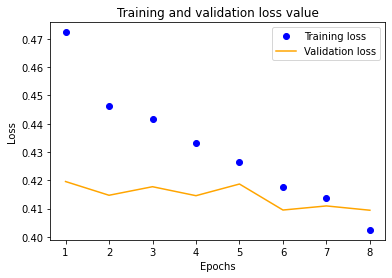

In [0]:
# let's see the training and validation loss by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_report(yxc_model, x_train, x_val, x_test, y_train, y_valid,y_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     14414
           1       0.71      0.47      0.56      4265

    accuracy                           0.84     18679
   macro avg       0.79      0.71      0.73     18679
weighted avg       0.82      0.84      0.82     18679

the confusion matrix for Train Dataset is:
[[13619   795]
 [ 2279  1986]]
----------------------------------------------------------------------------------------------------
the classification Report for val dataset is:
              precision    recall  f1-score   support

           0   

#### Model from Qi Zhou (The Winner Model)

In [0]:
model_joe = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model_joe.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(340,340,1))) 
model_joe.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_joe.add(tf.keras.layers.Dropout(0.2))

model_joe.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model_joe.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_joe.add(tf.keras.layers.Dropout(0.2))

model_joe.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_joe.add(tf.keras.layers.MaxPooling2D(pool_size=3))
model_joe.add(tf.keras.layers.Dropout(0.2))

model_joe.add(tf.keras.layers.Flatten())
model_joe.add(tf.keras.layers.Dense(128, activation='relu'))
model_joe.add(tf.keras.layers.Dropout(0.2))
model_joe.add(tf.keras.layers.Dense(128, activation='relu'))
model_joe.add(tf.keras.layers.Dropout(0.2))
model_joe.add(tf.keras.layers.Dense(64, activation='relu'))
model_joe.add(tf.keras.layers.Dropout(0.2))
model_joe.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_joe.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [0]:
history_joe = model_joe.fit(x_train, y_train, 
          validation_data=(x_val, y_valid),
          epochs=30, batch_size= 100, 
          verbose=1, callbacks=[es]) # 0 = dont show verbose, 1 = show it!

Epoch 1/30
187/187 [==============================] - 513s 3s/step - loss: 0.4857 - accuracy: 0.7771 - val_loss: 0.4543 - val_accuracy: 0.8078
Epoch 2/30
187/187 [==============================] - 510s 3s/step - loss: 0.4451 - accuracy: 0.7936 - val_loss: 0.4220 - val_accuracy: 0.8066
Epoch 3/30
187/187 [==============================] - 507s 3s/step - loss: 0.4387 - accuracy: 0.7946 - val_loss: 0.4202 - val_accuracy: 0.8106
Epoch 4/30
187/187 [==============================] - 506s 3s/step - loss: 0.4321 - accuracy: 0.8019 - val_loss: 0.4153 - val_accuracy: 0.8153
Epoch 5/30
187/187 [==============================] - 505s 3s/step - loss: 0.4203 - accuracy: 0.8101 - val_loss: 0.4213 - val_accuracy: 0.8108
Epoch 6/30
187/187 [==============================] - 505s 3s/step - loss: 0.4141 - accuracy: 0.8137 - val_loss: 0.4079 - val_accuracy: 0.8124
Epoch 7/30
187/187 [==============================] - 507s 3s/step - loss: 0.3975 - accuracy: 0.8238 - val_loss: 0.4237 - val_accuracy: 0.8083

In [0]:
model.save(path+'Project_model_joe.h5')

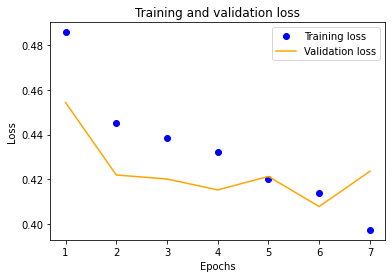

In [0]:
# let's see the training and validation loss by epoch
joe_history_dict = history_joe.history
loss_values = joe_history_dict['loss'] # you can change this
joe_val_loss_values = joe_history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, joe_val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_report(model_joe, x_train, x_val, x_test, y_train, y_valid,y_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     14414
           1       0.74      0.51      0.61      4265

    accuracy                           0.85     18679
   macro avg       0.81      0.73      0.76     18679
weighted avg       0.84      0.85      0.84     18679

the confusion matrix for Train Dataset is:
[[13665   749]
 [ 2083  2182]]
----------------------------------------------------------------------------------------------------
the classification Report for val dataset is:
              precision    recall  f1-score   support

           0   

#### Model From Swati

In [0]:
# Model created by swati
Swati_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
Swati_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(340,340,1))) 
Swati_model.add(tf.keras.layers.MaxPooling2D(pool_size=4))
Swati_model.add(tf.keras.layers.Dropout(0.5))

Swati_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
Swati_model.add(tf.keras.layers.MaxPooling2D(pool_size=4))
Swati_model.add(tf.keras.layers.Dropout(0.5))

Swati_model.add(tf.keras.layers.Flatten())
Swati_model.add(tf.keras.layers.Dense(64, activation='relu'))
Swati_model.add(tf.keras.layers.Dropout(0.5))
Swati_model.add(tf.keras.layers.Dense(64, activation='relu'))
Swati_model.add(tf.keras.layers.Dropout(0.5))
Swati_model.add(tf.keras.layers.Dense(32, activation='relu'))
Swati_model.add(tf.keras.layers.Dropout(0.3))
Swati_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

Swati_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_swati = Swati_model.fit(x_train, y_train, 
          validation_data=(x_val, y_valid),
          epochs=30, batch_size= 100, 
          verbose=1, callbacks=[es]) 

Epoch 1/30
187/187 [==============================] - 491s 3s/step - loss: 0.5256 - accuracy: 0.7647 - val_loss: 0.5225 - val_accuracy: 0.7853
Epoch 2/30
187/187 [==============================] - 498s 3s/step - loss: 0.4747 - accuracy: 0.7717 - val_loss: 0.5327 - val_accuracy: 0.7853
Epoch 3/30
187/187 [==============================] - 497s 3s/step - loss: 0.4700 - accuracy: 0.7717 - val_loss: 0.5112 - val_accuracy: 0.7853
Epoch 4/30
187/187 [==============================] - 486s 3s/step - loss: 0.4647 - accuracy: 0.7717 - val_loss: 0.5020 - val_accuracy: 0.7853
Epoch 5/30
187/187 [==============================] - 487s 3s/step - loss: 0.4621 - accuracy: 0.7717 - val_loss: 0.5159 - val_accuracy: 0.7853
Epoch 6/30
187/187 [==============================] - 482s 3s/step - loss: 0.4590 - accuracy: 0.7717 - val_loss: 0.5311 - val_accuracy: 0.7853
Epoch 00006: early stopping


In [0]:
model.save(path+'Project_model_swati.h5')

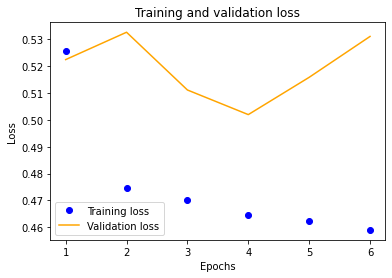

In [0]:
swati_history_dict = history_swati.history
loss_values = swati_history_dict['loss'] # you can change this
swati_val_loss_values = swati_history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, swati_val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_report(Swati_model, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     14414
           1       0.00      0.00      0.00      4265

    accuracy                           0.77     18679
   macro avg       0.39      0.50      0.44     18679
weighted avg       0.60      0.77      0.67     18679

the confusion matrix for Train Dataset is:
[[14414     0]
 [ 4265     0]]
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4191
           1       0.00      0.00      0.00      1146

    accuracy                           0.79      5337
   macro avg       0.39      0.50      0.44      5337
weighted avg       0.62      0.79      0.69      5337

the confusion matrix for val Dataset is:
[[4191    0]
 [1146    0]]
----------------------------------------------------------------------------------------------------
the classification Report for test dataset is:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2067
           1       0.00      0.00      0.00       601

    accuracy                           0.77      2668
   macro avg       0.39      0.50      0.44      2668
weighted avg       0.60      0.77      0.68      2668

the confusion matrix for Test Dataset is:
[[2067    0]
 [ 601    0]]


#### Model from Ashiya

In [0]:
AAA_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
AAA_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(340,340,1))) 
AAA_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
AAA_model.add(tf.keras.layers.Dropout(0.5))

AAA_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
AAA_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
AAA_model.add(tf.keras.layers.Dropout(0.5))

# Add one more layer
AAA_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
AAA_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
AAA_model.add(tf.keras.layers.Dropout(0.5))

AAA_model.add(tf.keras.layers.Flatten())
AAA_model.add(tf.keras.layers.Dense(256, activation='relu'))
AAA_model.add(tf.keras.layers.Dense(128, activation='relu'))
AAA_model.add(tf.keras.layers.Dense(32, activation='relu'))

AAA_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

AAA_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_AAA = Swati_model.fit(x_train, y_train, 
          validation_data=(x_val, y_valid),
          epochs=30, batch_size= 100, 
          verbose=1, callbacks=[es]) 

Epoch 1/30
187/187 [==============================] - 427s 2s/step - loss: 0.4489 - accuracy: 0.7717 - val_loss: 0.5466 - val_accuracy: 0.7853
Epoch 2/30
187/187 [==============================] - 426s 2s/step - loss: 0.4489 - accuracy: 0.7717 - val_loss: 0.5360 - val_accuracy: 0.7853
Epoch 3/30
187/187 [==============================] - 432s 2s/step - loss: 0.4466 - accuracy: 0.7717 - val_loss: 0.4991 - val_accuracy: 0.7853
Epoch 4/30
187/187 [==============================] - 439s 2s/step - loss: 0.4461 - accuracy: 0.7717 - val_loss: 0.5322 - val_accuracy: 0.7853
Epoch 5/30
187/187 [==============================] - 437s 2s/step - loss: 0.4446 - accuracy: 0.7717 - val_loss: 0.5417 - val_accuracy: 0.7853
Epoch 6/30
187/187 [==============================] - 423s 2s/step - loss: 0.4434 - accuracy: 0.7717 - val_loss: 0.5398 - val_accuracy: 0.7853
Epoch 00006: early stopping


In [0]:
model.save(path+'Project_model_aaa.h5')

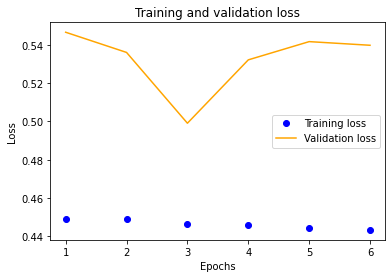

In [0]:
AAA_history_dict = history_AAA.history
loss_values = AAA_history_dict['loss'] # you can change this
AAA_val_loss_values = AAA_history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, AAA_val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_report(AAA_model, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14414
           1       0.23      1.00      0.37      4265

    accuracy                           0.23     18679
   macro avg       0.11      0.50      0.19     18679
weighted avg       0.05      0.23      0.08     18679

the confusion matrix for Train Dataset is:
[[    0 14414]
 [    0  4265]]
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4191
           1       0.21      1.00      0.35      1146

    accuracy                           0.21      5337
   macro avg       0.11      0.50      0.18      5337
weighted avg       0.05      0.21      0.08      5337

the confusion matrix for val Dataset is:
[[   0 4191]
 [   0 1146]]
----------------------------------------------------------------------------------------------------
the classification Report for test dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2067
           1       0.23      1.00      0.37       601

    accuracy                           0.23      2668
   macro avg       0.11      0.50      0.18      2668
weighted avg       0.05      0.23      0.08      2668

the confusion matrix for Test Dataset is:
[[   0 2067]
 [   0  601]]


## Assessment of Results

In [0]:
# model report for Cui's model
model_report(yxc_model, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     14414
           1       0.71      0.47      0.56      4265

    accuracy                           0.84     18679
   macro avg       0.79      0.71      0.73     18679
weighted avg       0.82      0.84      0.82     18679

the confusion matrix for Train Dataset is:
[[13619   795]
 [ 2279  1986]]
----------------------------------------------------------------------------------------------------
the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      4191
           1       0.59      0.42      0.49      1146

    accuracy                           0.81      5337
   macro avg       0.72      0.67      0.69      5337
weighted avg       0.80      0.81      0.80      5337

the confusion matrix for val Dataset is:
[[3852  339]
 [ 659  487]]
---------

In [0]:
# model report for Zhou's model
model_report(model_joe, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     14414
           1       0.74      0.51      0.61      4265

    accuracy                           0.85     18679
   macro avg       0.81      0.73      0.76     18679
weighted avg       0.84      0.85      0.84     18679

the confusion matrix for Train Dataset is:
[[13665   749]
 [ 2083  2182]]
----------------------------------------------------------------------------------------------------
the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4191
           1       0.57      0.44      0.50      1146

    accuracy                           0.81      5337
   macro avg       0.71      0.68      0.69      5337
weighted avg       0.79      0.81      0.80      5337

the confusion matrix for val Dataset is:
[[3806  385]
 [ 638  508]]
---------

In [0]:
# model report for Swati's model
model_report(Swati_model, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     14414
           1       0.00      0.00      0.00      4265

    accuracy                           0.77     18679
   macro avg       0.39      0.50      0.44     18679
weighted avg       0.60      0.77      0.67     18679

the confusion matrix for Train Dataset is:
[[14414     0]
 [ 4265     0]]
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4191
           1       0.00      0.00      0.00      1146

    accuracy                           0.79      5337
   macro avg       0.39      0.50      0.44      5337
weighted avg       0.62      0.79      0.69      5337

the confusion matrix for val Dataset is:
[[4191    0]
 [1146    0]]
----------------------------------------------------------------------------------------------------
the classification Report for test dataset is:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2067
           1       0.00      0.00      0.00       601

    accuracy                           0.77      2668
   macro avg       0.39      0.50      0.44      2668
weighted avg       0.60      0.77      0.68      2668

the confusion matrix for Test Dataset is:
[[2067    0]
 [ 601    0]]


In [0]:
# model report for Ashiya's model
model_report(AAA_model, x_train, x_val, x_test, y_train, y_valid,y_test)

the classification Report for train dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14414
           1       0.23      1.00      0.37      4265

    accuracy                           0.23     18679
   macro avg       0.11      0.50      0.19     18679
weighted avg       0.05      0.23      0.08     18679

the confusion matrix for Train Dataset is:
[[    0 14414]
 [    0  4265]]
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the classification Report for val dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4191
           1       0.21      1.00      0.35      1146

    accuracy                           0.21      5337
   macro avg       0.11      0.50      0.18      5337
weighted avg       0.05      0.21      0.08      5337

the confusion matrix for val Dataset is:
[[   0 4191]
 [   0 1146]]
----------------------------------------------------------------------------------------------------
the classification Report for test dataset is:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2067
           1       0.23      1.00      0.37       601

    accuracy                           0.23      2668
   macro avg       0.11      0.50      0.18      2668
weighted avg       0.05      0.23      0.08      2668

the confusion matrix for Test Dataset is:
[[   0 2067]
 [   0  601]]


##-End-